In [1]:
import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torchvision import models
import pytorch_ssim
from tqdm import tqdm
from PIL import Image
import imageio
from IPython.display import display, clear_output

import cppn

In [2]:
class SaveOutput:
    def __init__(self):        
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []
        
class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        f = input.view(b, c, h*w) #bxcx(hxw)
        # torch.bmm(batch1, batch2, out=None)
        # batch1 : bxmxp, batch2 : bxpxn -> bxmxn
        G = torch.bmm(f, f.transpose(1, 2)) # f: bxcx(hxw), f.transpose: bx(hxw)xc -> bxcxc
        return G.div_(h*w)

In [3]:
vgg19 = models.vgg19(pretrained=True)
vgg_readout = vgg19.features[:29].cuda()

save_features = SaveOutput()
save_content = SaveOutput()

feature_layers = [1, 5, 11, 26]
content_layers = [20]
f_weights = [1] * len(feature_layers)
c_weights = [0] * len(content_layers)
multiplier = 1

weights = f_weights + c_weights
loss_layers = feature_layers + content_layers
layer_weights = torch.from_numpy(np.multiply(weights, multiplier)).float().cuda()

hook_handles = []
for i, layer in enumerate(vgg_readout.modules()):
    if i in feature_layers:
        handle = layer.register_forward_hook(save_features)
        hook_handles.append(handle)
    elif i in content_layers:
        handle = layer.register_forward_hook(save_content)
        hook_handles.append(handle)

## Style image

In [4]:
net_size = [512, 64, 32, 16, 16, 8] 
dim_z = 16
dim_c = 3
print(net_size)

G = cppn.CPPN(net_size, dim_z, dim_c).cuda()
sampler = cppn.Sampler(G)

[512, 64, 32, 16, 16, 8]


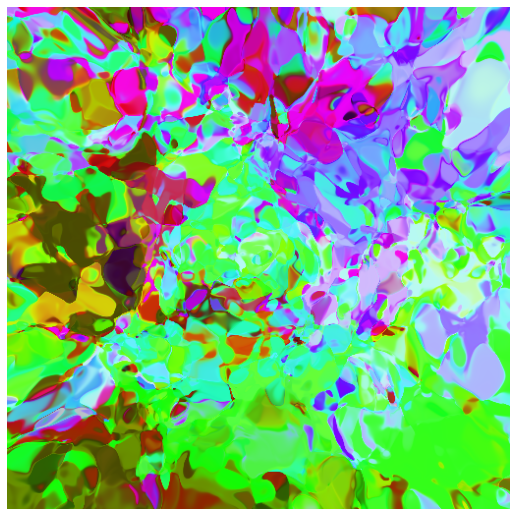

In [5]:
G.reinit(empty_cache=True)
gscale = 1
scale = 15
xres = 512
yres = 512
zscale = 4
nscale = 0

z =  torch.randn(1, dim_z).cuda()
delta_v = torch.randn(1, dim_z).cuda() 
z2 = z + 0.02*delta_v
coords = G._coordinates(scale*gscale,
                           xres, yres, z*zscale*gscale)

x = sampler.generate_img(G, z*zscale, scale, xres, yres, coords=coords)
sampler.imshow(x)

## Content image

In [6]:
target_file = '/notebooks/target/eye2.jpg'
img = Image.open(target_file)
h, w, *_ = np.array(img).shape
aspectratio = h / w
XRES = 512
YRES = int( XRES * aspectratio )

TARGET = np.array(img.resize((XRES, YRES), Image.ANTIALIAS))
t_img = torch.from_numpy(TARGET).float().cuda().permute(2, 0, 1).unsqueeze(0).contiguous() / 255

## Initialize a random image

In [7]:
class Pixel(nn.Module):
    def __init__(self, image_shape):
        super().__init__()
        self.pixel_vals = nn.Parameter(torch.rand(size=image_shape, device='cuda'))
            
    def forward(self):
        return torch.sigmoid(self.pixel_vals)

In [8]:
# optimImg = nn.Parameter(torch.rand(size=t_img.shape, device='cuda') * 255.0)
# optimizer = torch.optim.LBFGS([optimImg])


optimImg = Pixel(t_img.shape).to('cuda')
optimizer = torch.optim.LBFGS(optimImg.parameters())

In [9]:
with torch.no_grad():
    # style loss
    coords = G._coordinates(scale*gscale, XRES, YRES, z*zscale*gscale)
    x = sampler.generate_img(G, z*zscale, scale, XRES, YRES, coords=coords, tensor=True)# * 255.0
    
    vgg_readout(x.permute(2, 0, 1).unsqueeze(0))
    f_targets = [GramMatrix()(o) for o in save_features.outputs]
    save_features.clear()
    save_content.clear()
    
    # content loss
    vgg_readout(t_img)
    c_targets = [GramMatrix()(o) for o in save_content.outputs]
    save_content.clear()
    save_features.clear()
    
targets = f_targets + c_targets

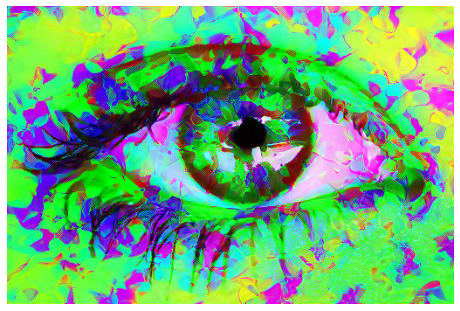

<Figure size 432x288 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

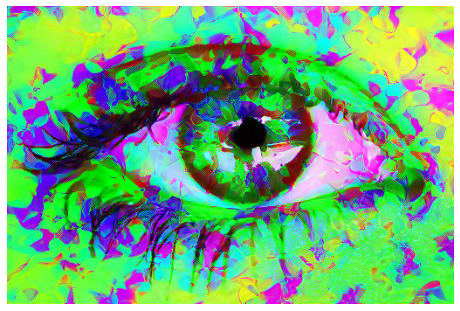

In [10]:
no_iter = 100

for iteration in range(1, no_iter):
    losses = []
    def cl():
        optimizer.zero_grad()
        vgg_readout(optimImg())
        f_out = save_features.outputs
        c_out = save_content.outputs
        save_features.clear()
        save_content.clear()
        
        out_gram = [GramMatrix()(o) for o in (f_out + c_out)]
        losses = [nn.MSELoss()(out_gram[i], targets[i]) * layer_weights[i] for i in range(len(out_gram))]
        losses.append(nn.MSELoss()(optimImg().mean(1), t_img.mean(1)) * 1000)
        totalLoss = sum(losses)
    
#         totalLoss = -nn.MSELoss()(optimImg, t_img) * 1000
        
        totalLoss.backward()
        losses.append(totalLoss.item())
        return totalLoss
    optimizer.step(cl)
#     optimImg = torch.clip(optimImg.detach(),0, 255)

    if iteration%3 == 0:
        print('Iteration [%d]/[%d]'%(iteration,no_iter))
        
        nx = optimImg()[0].detach().cpu().numpy().transpose(1, 2, 0)#/255.0
        plt.clf()
        fig, axes = plt.subplots(1)
        axes.imshow(nx)
        axes.set_axis_off()
        plt.gcf().set_size_inches((8,8))
        clear_output(wait=True)
        display(plt.gcf())
        time.sleep(0.01)
    